## Best Model: XGBoost | with Time Feature | SMOTE  resampling

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report
)
import pickle
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("../dataset/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# feature selection and labels inclusive the time column
X, y = data.drop("Class", axis=1), data["Class"]
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [7]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [8]:
# resampling using the smote algorithm
smote = SMOTE(random_state=21)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(f"Post SMOTE --> X: {X_resampled.shape}, y: {y_resampled.shape}")

Post SMOTE --> X: (568630, 30), y: (568630,)


In [9]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    stratify=y_resampled,
    random_state=21
)
print(
    X.shape,
    X_train.shape,
    X_test.shape
)

(284807, 30) (454904, 30) (113726, 30)


In [11]:
# building the XGBClassifier model
scale_pos_weight = 1 

model = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weights=1,
    reg_lambda=1.0,
    gamma=0.0,
    objective="binary:logistic",
    tree_methods="hist",
    eval_metrics="aucpr",
    scale_pos_weight=scale_pos_weight,
    random_state=21,
    use_label_encoder=False
)

In [12]:
# model training
model.fit(X_train, y_train)

/home/kami/miniconda3/envs/std-prog/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:00:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "eval_metrics", "min_child_weights", "tree_methods", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
# model evaluation --> prediction
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [16]:
# model evaluation --> metrics
roc = roc_auc_score(y_test, y_pred)
pr_auc = average_precision_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
clf_report = classification_report(y_test, y_pred, digits=4)

In [17]:
# model evaluation --> metrics results
print("XGBoost (with Time | SMOTE) Results")
print(f"ROC AUC: {roc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print(f"Classification Report:\n{clf_report}")

XGBoost (with Time | SMOTE) Results
ROC AUC: 0.9999
PR AUC: 1.0000
Confusion Matrix:
 [[56852    11]
 [    0 56863]]
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9998    0.9999     56863
           1     0.9998    1.0000    0.9999     56863

    accuracy                         0.9999    113726
   macro avg     0.9999    0.9999    0.9999    113726
weighted avg     0.9999    0.9999    0.9999    113726



In [31]:
# feature importance
importances = model.feature_importances_
feature_names = X_train.columns
feature_imp_df = pd.DataFrame(
    {
        "Features": feature_names,
        "Importance": importances
    }
).sort_values(
    by="Importance",
    ascending=False
)

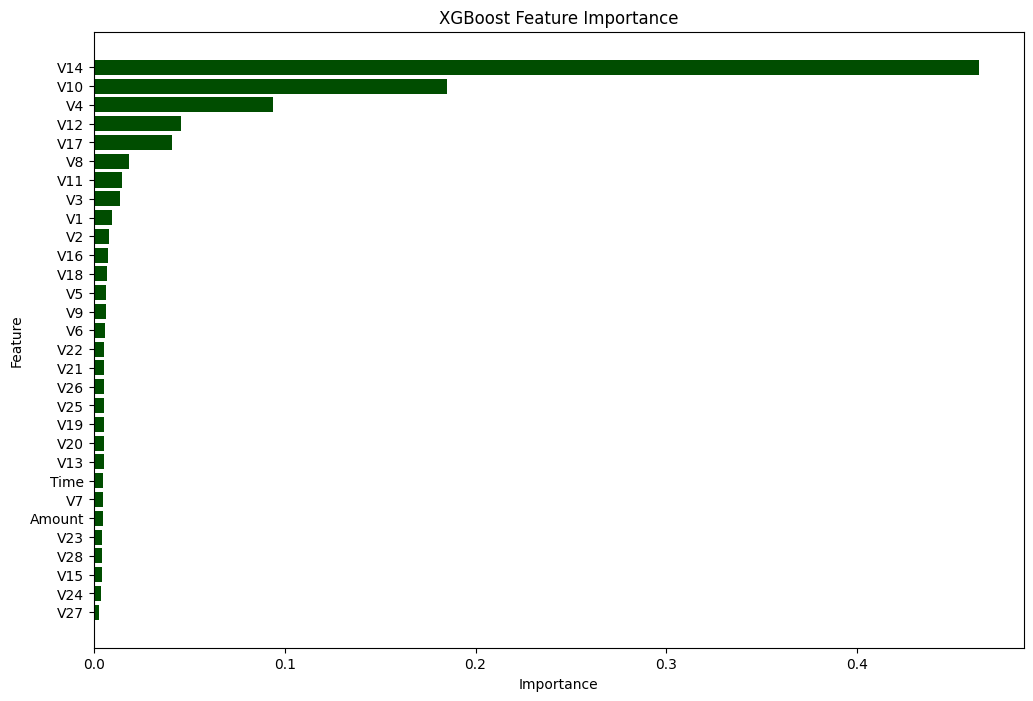

In [34]:
# plotting the feature importance charts
plt.figure(figsize=(12, 8))
plt.barh(
    feature_imp_df["Features"],
    feature_imp_df["Importance"],
    color="#004d00" 
)
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [36]:
# saving the model with pickle lib
with open("../models/model.sav", "wb") as f:
    pickle.dump(model, f)